In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    roc_auc_score,
    mean_squared_error,
    r2_score
)
from sklearn.model_selection import (
    GridSearchCV,
    cross_validate,
    train_test_split,
    cross_val_score
)
from sklearn.preprocessing import (
    LabelBinarizer,
    LabelEncoder,
    StandardScaler
)

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

import joblib

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
mohs_test_with_complexity_scores = pd.read_csv("mohs_test_with_complexity_scores.csv")

features = mohs_test_with_complexity_scores.iloc[:, 3:12]

features = features.rename(columns=lambda x: x.strip().replace("  ", " "))

for col in features.columns:
    if features[col].dtype == 'object':
        features[col] = features[col].astype('category')


### Using features to predict `Visit Complexity Category KMeans` with XGBoost

In [3]:
target = mohs_test_with_complexity_scores['Visit Complexity Category KMeans']
le = LabelEncoder()
target_encoded = le.fit_transform(target)
features_encoded = pd.get_dummies(features)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    features_encoded, target_encoded, test_size=0.4, random_state=42
)

xgb_model_cat_complexity = XGBClassifier(
    objective='multi:softprob',  
    eval_metric='mlogloss',     
    use_label_encoder=True,   
    random_state=42
)

xgb_model_cat_complexity.fit(X_train, y_train)

y_pred = xgb_model_cat_complexity.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[ 476   11   95]
 [  17 1700  382]
 [  61  377  881]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84       582
           1       0.81      0.81      0.81      2099
           2       0.65      0.67      0.66      1319

    accuracy                           0.76      4000
   macro avg       0.77      0.77      0.77      4000
weighted avg       0.77      0.76      0.77      4000



In [5]:
y_proba = xgb_model_cat_complexity.predict_proba(X_test)

lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)

roc_auc = roc_auc_score(y_test_binarized, y_proba, average='macro', multi_class='ovr')
print(f"Multiclass ROC AUC (macro average): {roc_auc:.4f}")

Multiclass ROC AUC (macro average): 0.9136


### Using features to predict `Visit Complexity Category KMeans` with XGBoost (Continuous)

In [6]:
target = mohs_test_with_complexity_scores['Normalized Visit Complexity Score KMeans']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.4, random_state=42)

In [7]:
xgb_model_reg_complexity_continuous = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    use_label_encoder=True,
    enable_categorical=True
)

xgb_model_reg_complexity_continuous.fit(features, target)

scoring = {
    'rmse': make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False)),  # RMSE
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}

cv_results = cross_validate(
    xgb_model_reg_complexity_continuous, 
    features, 
    target, 
    cv=10, 
    scoring=scoring
)

mean_rmse = np.mean(cv_results['test_rmse'])
mean_mae = -np.mean(cv_results['test_mae'])
mean_r2 = np.mean(cv_results['test_r2'])

print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Mean MAE: {mean_mae:.2f}")
print(f"Mean R²: {mean_r2:.2f}")

Mean RMSE: 0.17
Mean MAE: 0.13
Mean R²: 0.66


### Using features to predict `Visit Duration` with XGBoost

In [8]:
target = mohs_test_with_complexity_scores['Duration of Visit (min)']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.4, random_state=42)


In [9]:
xgb_model_reg_visit_duration = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    use_label_encoder=True,
    enable_categorical=True
)

xgb_model_reg_visit_duration.fit(features, target)

joblib.dump(xgb_model_reg_visit_duration, 'xgb_model_regressor.joblib')

scoring = {
    'rmse': make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False)),  # RMSE
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}

cv_results = cross_validate(
    xgb_model_reg_visit_duration, 
    features, 
    target, 
    cv=10, 
    scoring=scoring
)

mean_rmse = np.mean(cv_results['test_rmse'])
mean_mae = -np.mean(cv_results['test_mae'])
mean_r2 = np.mean(cv_results['test_r2'])

print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Mean MAE: {mean_mae:.2f}")
print(f"Mean R²: {mean_r2:.2f}")

Mean RMSE: 16.27
Mean MAE: 12.73
Mean R²: 0.92


### Using features to predict `Anesthetic Amount (ml)` with XGBoost

In [10]:
target = mohs_test_with_complexity_scores['Anesthetic Amount (ml)']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.4, random_state=42)

In [11]:
xgb_model_reg_aneshetic_amount = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    use_label_encoder=True,
    enable_categorical=True
)

xgb_model_reg_aneshetic_amount.fit(features, target)

joblib.dump(xgb_model_reg_aneshetic_amount, 'xgb_model_regressor.joblib')

scoring = {
    'rmse': make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False)),  # RMSE
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}

cv_results = cross_validate(
    xgb_model_reg_aneshetic_amount, 
    features, 
    target, 
    cv=10, 
    scoring=scoring
)

mean_rmse = np.mean(cv_results['test_rmse'])
mean_mae = -np.mean(cv_results['test_mae'])
mean_r2 = np.mean(cv_results['test_r2'])

print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Mean MAE: {mean_mae:.2f}")
print(f"Mean R²: {mean_r2:.2f}")

Mean RMSE: 2.10
Mean MAE: 1.68
Mean R²: 0.87


### Using features to predict `Number of stages` with XGBoost (Continuous)

In [12]:
target = mohs_test_with_complexity_scores['Number of stages']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.4, random_state=42)

In [13]:
xgb_model_reg_stages_continuous = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    use_label_encoder=True,
    enable_categorical=True
)

xgb_model_reg_stages_continuous.fit(features, target)

scoring = {
    'rmse': make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False)),
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}

cv_results = cross_validate(
    xgb_model_reg_stages_continuous, 
    features, 
    target, 
    cv=10, 
    scoring=scoring
)

mean_rmse = np.mean(cv_results['test_rmse'])
mean_mae = -np.mean(cv_results['test_mae'])
mean_r2 = np.mean(cv_results['test_r2'])

print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Mean MAE: {mean_mae:.2f}")
print(f"Mean R²: {mean_r2:.2f}")

Mean RMSE: 0.67
Mean MAE: 0.51
Mean R²: 0.34


### Using features to predict `Number of stages` with XGBoost (Categorical)

In [17]:
target = mohs_test_with_complexity_scores['Number of stages'].astype('category')

le = LabelEncoder()
target = le.fit_transform(target)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.4, random_state=42)

In [18]:
xgb_model_cat_stages = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(target)),
    random_state=42,
    use_label_encoder=True,
    enable_categorical=True
)

xgb_model_cat_stages.fit(features, target)

scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted')
}

cv_results = cross_validate(
    xgb_model_cat_stages,
    features,
    target,
    cv=10,
    scoring=scoring
)

mean_acc = np.mean(cv_results['test_accuracy'])
mean_f1 = np.mean(cv_results['test_f1_weighted'])
mean_precision = np.mean(cv_results['test_precision_weighted'])

print(f"Mean Accuracy: {mean_acc:.2f}")
print(f"Mean Weighted F1: {mean_f1:.2f}")
print(f"Mean Weighted Precision: {mean_precision:.2f}")


Mean Accuracy: 0.54
Mean Weighted F1: 0.53
Mean Weighted Precision: 0.54


In [107]:
# Create output directory for all models
output_dir = "models"
os.makedirs(output_dir, exist_ok=True)

# -----------------------------
# Save classification models
# -----------------------------
joblib.dump(
    xgb_model_cat_complexity, 
    os.path.join(output_dir, "xgb_classifier_visit_complexity_kmeans.pkl")
)

joblib.dump(
    xgb_model_cat_stages, 
    os.path.join(output_dir, "xgb_classifier_number_of_stages.pkl")
)

# -----------------------------
# Save regression models
# -----------------------------
joblib.dump(
    xgb_model_reg_complexity_continuous, 
    os.path.join(output_dir, "xgb_regressor_normalized_visit_complexity_kmeans.pkl")
)

joblib.dump(
    xgb_model_reg_visit_duration, 
    os.path.join(output_dir, "xgb_regressor_visit_duration.pkl")
)

joblib.dump(
    xgb_model_reg_aneshetic_amount, 
    os.path.join(output_dir, "xgb_regressor_anesthetic_amount.pkl")
)

joblib.dump(
    xgb_model_reg_stages_continuous, 
    os.path.join(output_dir, "xgb_regressor_number_of_stages.pkl")
)

# -----------------------------
# Optional: Save encoders or feature columns if needed
# -----------------------------
# Example for your LabelEncoder for visit complexity
joblib.dump(
    le, 
    os.path.join(output_dir, "label_encoder_visit_complexity_kmeans.pkl")
)

# Example for saving one-hot encoded column names
joblib.dump(
    features_encoded.columns.tolist(), 
    os.path.join(output_dir, "model1_features.pkl")
)

['models/model1_features.pkl']

### Checking Feature Importance 

Some of the features in models dont change the repsonse

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ensure categorical features are encoded numerically first!
X = features.copy()
for col in X.select_dtypes(include='category').columns:
    X[col] = pd.Categorical(X[col]).codes
for col in X.select_dtypes(include='object').columns:
    X[col] = pd.Categorical(X[col]).codes

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values(by='VIF', ascending=False))


                      Feature       VIF
6                 Age (years)  6.709702
3    Wound Management (H/M/L)  5.359033
0            Lesion Size (cm)  2.082624
4            Location (H/M/L)  1.907504
5      Treatment Delay (days)  1.722467
2  Aggressive Histology (Y/N)  1.247175
8         Bleeding Risk (Y/N)  1.232430
7      Immunosuppressed (Y/N)  1.109978
1       Recurrent Tumor (Y/N)  1.107706



=== Feature Importance for Anesthetic Amount ===
                      Feature  Importance
3    Wound Management (H/M/L)    0.299520
0           Lesion  Size (cm)    0.198907
8         Bleeding Risk (Y/N)    0.169373
2  Aggressive Histology (Y/N)    0.117729
7      Immunosuppressed (Y/N)    0.087350
1       Recurrent Tumor (Y/N)    0.078633
6                 Age (years)    0.022730
4            Location (H/M/L)    0.017624
5      Treatment Delay (days)    0.008135


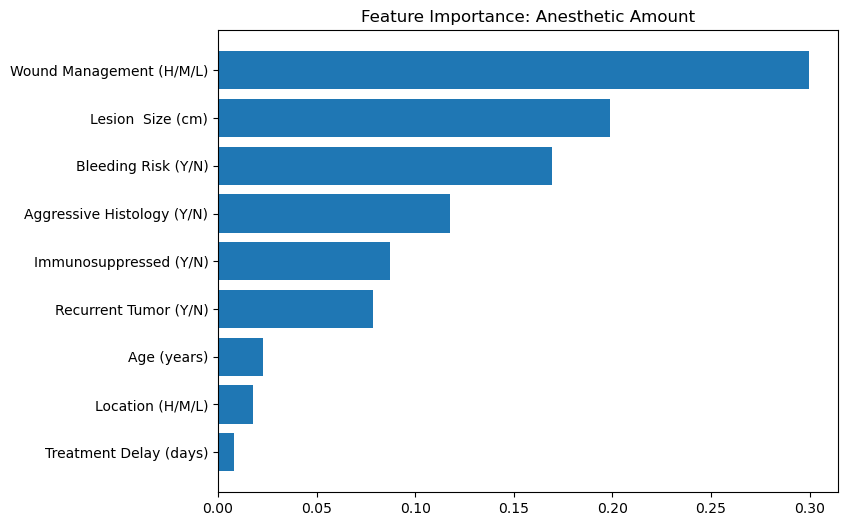


=== Feature Importance for Normalized Complexity Score ===
                      Feature  Importance
0           Lesion  Size (cm)    0.211212
2  Aggressive Histology (Y/N)    0.170960
1       Recurrent Tumor (Y/N)    0.163946
3    Wound Management (H/M/L)    0.129521
7      Immunosuppressed (Y/N)    0.116334
8         Bleeding Risk (Y/N)    0.088358
4            Location (H/M/L)    0.070564
6                 Age (years)    0.027487
5      Treatment Delay (days)    0.021618


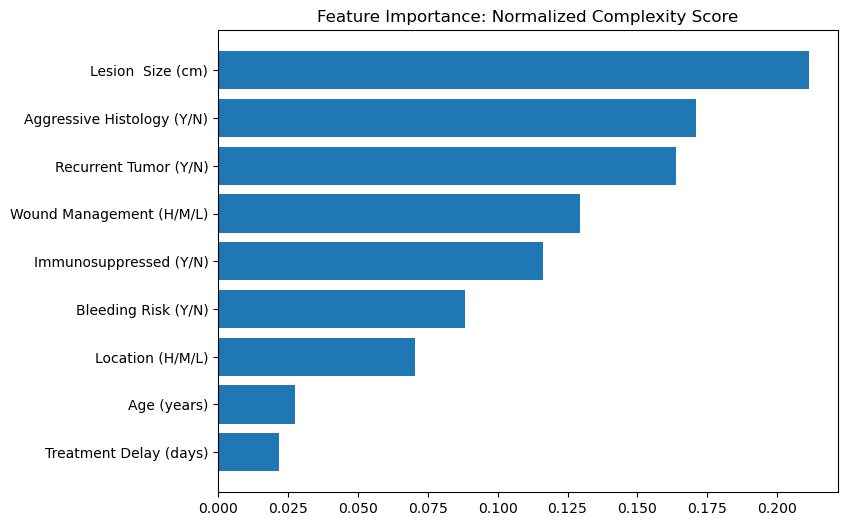


=== Feature Importance for Number of Stages ===
                      Feature  Importance
1       Recurrent Tumor (Y/N)    0.381816
2  Aggressive Histology (Y/N)    0.177264
4            Location (H/M/L)    0.149204
7      Immunosuppressed (Y/N)    0.126492
0           Lesion  Size (cm)    0.057700
8         Bleeding Risk (Y/N)    0.029810
5      Treatment Delay (days)    0.027653
6                 Age (years)    0.026126
3    Wound Management (H/M/L)    0.023935


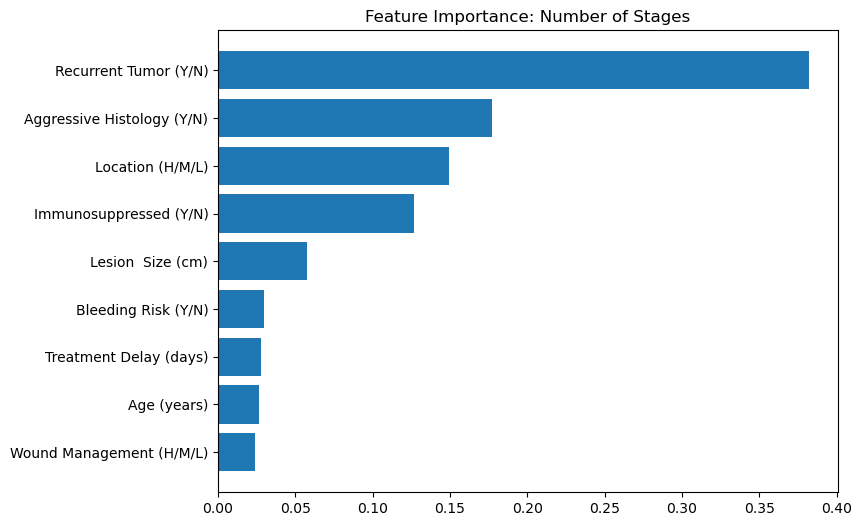


=== Feature Importance for Visit Duration ===
                      Feature  Importance
0           Lesion  Size (cm)    0.300441
3    Wound Management (H/M/L)    0.290479
2  Aggressive Histology (Y/N)    0.130709
8         Bleeding Risk (Y/N)    0.084496
1       Recurrent Tumor (Y/N)    0.075782
7      Immunosuppressed (Y/N)    0.057431
4            Location (H/M/L)    0.031608
6                 Age (years)    0.018328
5      Treatment Delay (days)    0.010725


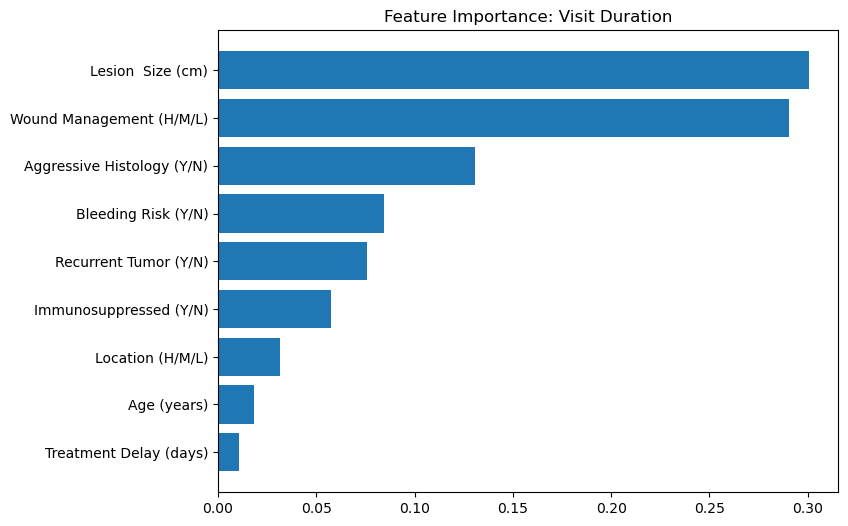

In [27]:
model_names = [
    "Anesthetic Amount",
    "Normalized Complexity Score",
    "Number of Stages",
    "Visit Duration"
]

models = [
    xgb_model_reg_aneshetic_amount, 
    xgb_model_reg_complexity_continuous, 
    xgb_model_reg_stages_continuous, 
    xgb_model_reg_visit_duration
]

# Full feature list from training (for most models)
full_features = [
    'Lesion  Size (cm)',
    'Recurrent Tumor (Y/N)',
    'Aggressive Histology (Y/N)',
    'Wound Management (H/M/L)',
    'Location (H/M/L)',
    'Treatment Delay (days)',
    'Age (years)',
    'Immunosuppressed (Y/N)',
    'Bleeding Risk (Y/N)',
    'Greater Average Time (Y/N)'
]

# Reduced feature list (if needed for models with 9 features, like Anesthetic Amount)
reduced_features = [f for f in full_features if f != 'Greater Average Time (Y/N)']

for name, model in zip(model_names, models): 
    importances = model.feature_importances_
    n_importances = len(importances)

    if n_importances == len(full_features):
        feature_list = full_features
    elif n_importances == len(reduced_features):
        feature_list = reduced_features
    else:
        feature_list = [f"Feature_{i}" for i in range(n_importances)]
        print(f"⚠️ Warning: {name} feature count mismatch. Using generic feature names.")

    importance_df = pd.DataFrame({
        'Feature': feature_list,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print(f"\n=== Feature Importance for {name} ===")
    print(importance_df)

    # Optional plot:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.gca().invert_yaxis()
    plt.title(f"Feature Importance: {name}")
    plt.show()